In [40]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import gc
import codecs
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
%matplotlib inline
pal = sns.color_palette()


# ReadMe

- All variables are started with "dt_" for easy reference
- For constant variables use "dt_CAPS"

In [42]:
#Paths
dt_QUORA_DATA_DIR = "/opt/datasets/quora/"
dt_TRAIN_CSV = dt_QUORA_DATA_DIR+'train.csv'
dt_TEST_CSV = dt_QUORA_DATA_DIR+'test.csv'

dt_GLOVE_DATA_DIR="/opt/datasets/glove/"
dt_glove_840B_300d =dt_glove_data_dir+'glove.840B.300d.txt'
dt_GLOVE_DATA_FILE=dt_glove_840B_300d

In [34]:
dt_EMBEDDING_DIM = 300
dt_MAX_SEQUENCE_LENGTH = 30
dt_MAX_NB_WORDS = 200000
dt_EMBEDDING_DIM = 300
dt_VALIDATION_SPLIT = 0.01

# Data Analysis

In [33]:
df_train = pd.read_csv(dt_train_csv)
df_test = pd.read_csv(dt_test_csv)
df_train.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [18]:
dt_total_ques_pairs = len(df_train)
print('Total number of question pairs for training: {}'.format(dt_total_ques_pairs))

dt_duplicate_ques_pairs = round(df_train['is_duplicate'].mean()*100, 2)
print('Duplicate pairs: {}%'.format(dt_duplicate_ques_pairs))

dt_all_qids = pd.Series(df_train['qid1'].tolist() + df_train['qid2'].tolist())
dt_unique_qids = len(np.unique(dt_all_qids))
print('Total number of questions in the training data: {}'.format(dt_unique_qids))

print('Number of questions that appear multiple times: {}'.format(np.sum(dt_all_qids.value_counts() > 1)))

Total number of question pairs for training: 404290
Duplicate pairs: 36.92%
Total number of questions in the training data: 537933
Number of questions that appear multiple times: 111780


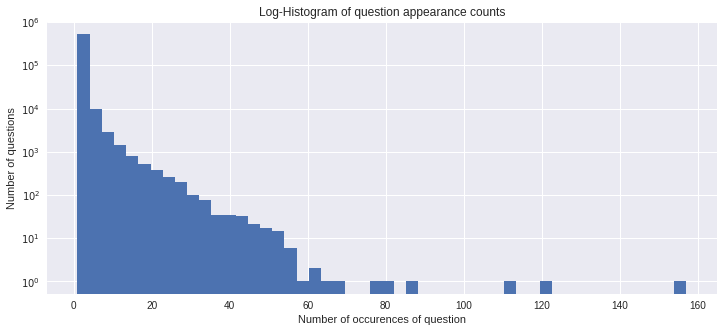

In [19]:
plt.figure(figsize=(12, 5))
plt.hist(dt_all_qids.value_counts(), bins=50)
plt.yscale('log', nonposy='clip')
plt.title('Log-Histogram of question appearance counts')
plt.xlabel('Number of occurences of question')
plt.ylabel('Number of questions')
print()

# Text Analysis

mean-train 59.82 std-train 31.96 mean-test 60.07 std-test 31.62 max-train 1169.00 max-test 1176.00


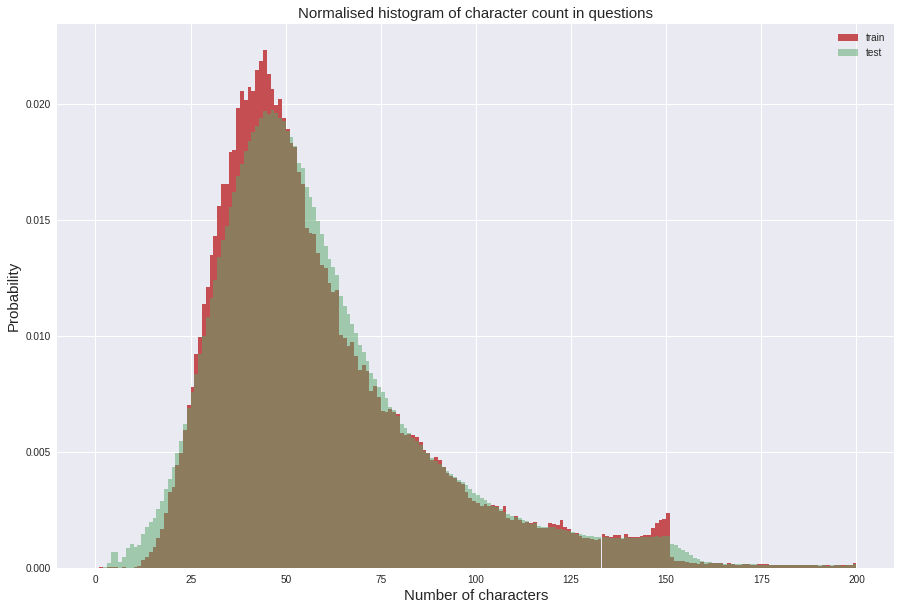

In [20]:
train_qs = pd.Series(df_train['question1'].tolist() + df_train['question2'].tolist()).astype(str)
test_qs = pd.Series(df_test['question1'].tolist() + df_test['question2'].tolist()).astype(str)

dist_train = train_qs.apply(len)
dist_test = test_qs.apply(len)
plt.figure(figsize=(15, 10))
plt.hist(dist_train, bins=200, range=[0, 200], color=pal[2], normed=True, label='train')
plt.hist(dist_test, bins=200, range=[0, 200], color=pal[1], normed=True, alpha=0.5, label='test')
plt.title('Normalised histogram of character count in questions', fontsize=15)
plt.legend()
plt.xlabel('Number of characters', fontsize=15)
plt.ylabel('Probability', fontsize=15)

print('mean-train {:.2f} std-train {:.2f} mean-test {:.2f} std-test {:.2f} max-train {:.2f} max-test {:.2f}'.format(dist_train.mean(), 
                          dist_train.std(), dist_test.mean(), dist_test.std(), dist_train.max(), dist_test.max()))

(-0.5, 1439.5, 1079.5, -0.5)

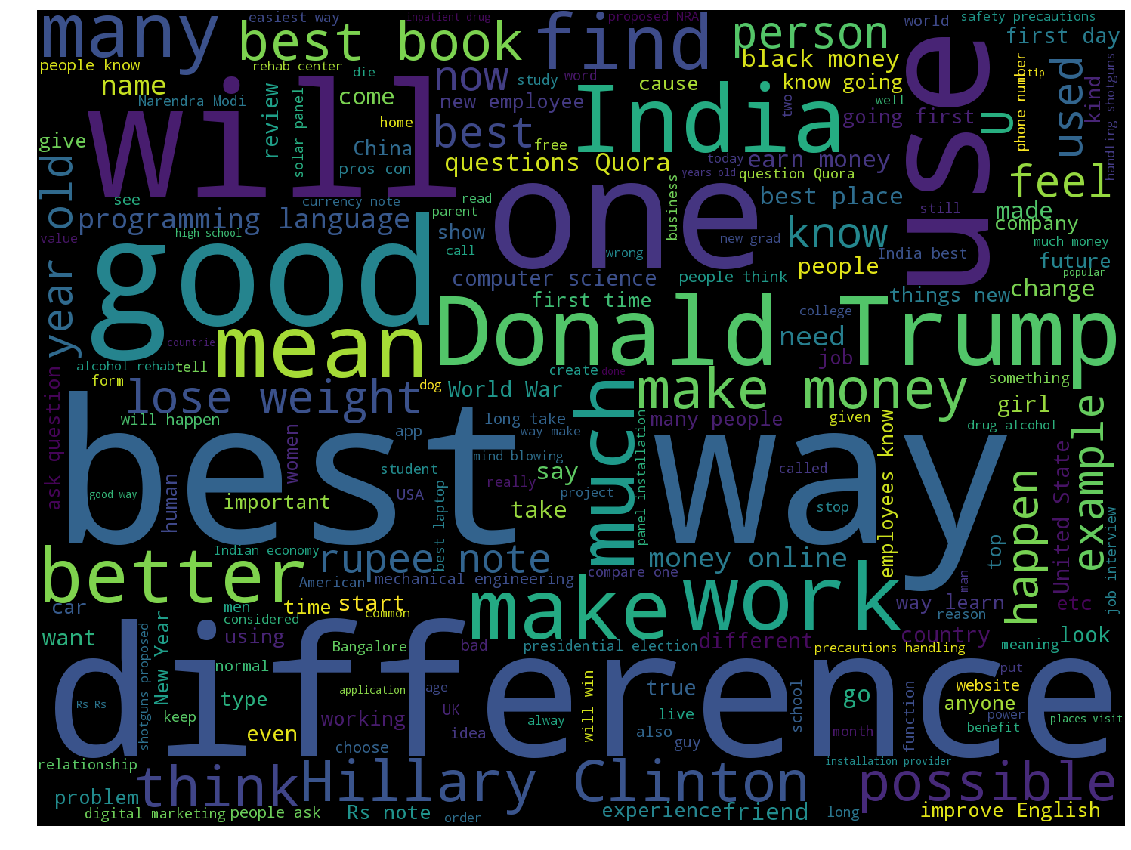

In [21]:
from wordcloud import WordCloud
cloud = WordCloud(width=1440, height=1080).generate(" ".join(train_qs.astype(str)))
plt.figure(figsize=(20, 15))
plt.imshow(cloud)
plt.axis('off')

# Data Preprocessing

In [60]:
dt_train_feature_1_text = df_train['question1'].tolist()
dt_train_feature_1_text[:10]

['What is the step by step guide to invest in share market in india?',
 'What is the story of Kohinoor (Koh-i-Noor) Diamond?',
 'How can I increase the speed of my internet connection while using a VPN?',
 'Why am I mentally very lonely? How can I solve it?',
 'Which one dissolve in water quikly sugar, salt, methane and carbon di oxide?',
 'Astrology: I am a Capricorn Sun Cap moon and cap rising...what does that say about me?',
 'Should I buy tiago?',
 'How can I be a good geologist?',
 'When do you use シ instead of し?',
 'Motorola (company): Can I hack my Charter Motorolla DCX3400?']

In [61]:
dt_train_feature_2_text = df_train['question2'].tolist()
dt_train_feature_2_text[:10]

['What is the step by step guide to invest in share market?',
 'What would happen if the Indian government stole the Kohinoor (Koh-i-Noor) diamond back?',
 'How can Internet speed be increased by hacking through DNS?',
 'Find the remainder when [math]23^{24}[/math] is divided by 24,23?',
 'Which fish would survive in salt water?',
 "I'm a triple Capricorn (Sun, Moon and ascendant in Capricorn) What does this say about me?",
 'What keeps childern active and far from phone and video games?',
 'What should I do to be a great geologist?',
 'When do you use "&" instead of "and"?',
 'How do I hack Motorola DCX3400 for free internet?']

In [62]:
dt_train_target = df_train['is_duplicate'].tolist()
print(dt_target[:10])

[0, 0, 0, 0, 0, 1, 0, 1, 0, 0]


In [63]:
dt_test_feature_1_text = df_test['question1'].tolist()
dt_test_feature_1_text[:5]

['How does the Surface Pro himself 4 compare with iPad Pro?',
 'Should I have a hair transplant at age 24? How much would it cost?',
 'What but is the best way to send money from China to the US?',
 'Which food not emulsifiers?',
 'How "aberystwyth" start reading?']

In [64]:
dt_test_feature_2_text = df_test['question2'].tolist()
dt_test_feature_2_text[:5]

['Why did Microsoft choose core m3 and not core i3 home Surface Pro 4?',
 'How much cost does hair transplant require?',
 'What you send money to China?',
 'What foods fibre?',
 'How their can I start reading?']

In [65]:
dt_one_time_run = True
if(dt_one_time_run):
    %%time
    print('Indexing word vectors.')
    embeddings_index = {}
    f = codecs.open(dt_GLOVE_DATA_FILE, encoding='utf-8')
    for line in f:
        values = line.split(' ')
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
    f.close()
    print('Found %s word vectors.' % len(embeddings_index))
else:
    print('Skipped to save some time!')
dt_one_time_run = False    

Indexing word vectors.
Found 2196017 word vectors.
CPU times: user 4min 55s, sys: 4.79 s, total: 5min
Wall time: 6min 56s


In [58]:
# embeddings_index['best']

In [66]:
%%time
dt_all_questions_text = dt_train_feature_1_text + dt_train_feature_2_text + dt_test_feature_1_text + dt_test_feature_2_text

CPU times: user 184 ms, sys: 60 ms, total: 244 ms
Wall time: 19.6 s


In [69]:
print("Total number of questions in Quora dataset: {}".format(len(dt_all_questions_text)))

Total number of questions in Quora dataset: 5500172


# Build the Graph

In [70]:
lstm_size = 256
lstm_layers = 1
batch_size = 250
learning_rate = 0.001

In [ ]:
# Create the graph object
graph = tf.Graph()
# Add nodes to the graph
with graph.as_default():
    inputs_ = tf.placeholder(tf.float32, [None, None, None], name='inputs') #[Number of ques, Seq/Ques Length, Embed Dims]
    labels_ = tf.placeholder(tf.float32, [None, None], name='labels')
    keep_prob = tf.placeholder(tf.float32, name='keep_prob')